# Recreate wgan from just pytorch

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.datasets import *
import gzip
import torch.nn as nn
import random

In [3]:
import torch
torch.cuda.current_device()

0

In [4]:
torch.cuda.is_available()

True

In [5]:
path = untar_data(URLs.LSUN_BEDROOMS)
CSV_PATH = path/"files.csv"
IMG_PATH = path

In [6]:
path

PosixPath('/home/luan/.fastai/data/bedroom')

In [7]:
path.ls()

[PosixPath('/home/luan/.fastai/data/bedroom/files_sample.csv'),
 PosixPath('/home/luan/.fastai/data/bedroom/0'),
 PosixPath('/home/luan/.fastai/data/bedroom/7'),
 PosixPath('/home/luan/.fastai/data/bedroom/3'),
 PosixPath('/home/luan/.fastai/data/bedroom/2'),
 PosixPath('/home/luan/.fastai/data/bedroom/9'),
 PosixPath('/home/luan/.fastai/data/bedroom/c'),
 PosixPath('/home/luan/.fastai/data/bedroom/d'),
 PosixPath('/home/luan/.fastai/data/bedroom/1'),
 PosixPath('/home/luan/.fastai/data/bedroom/a'),
 PosixPath('/home/luan/.fastai/data/bedroom/e'),
 PosixPath('/home/luan/.fastai/data/bedroom/8'),
 PosixPath('/home/luan/.fastai/data/bedroom/4'),
 PosixPath('/home/luan/.fastai/data/bedroom/6'),
 PosixPath('/home/luan/.fastai/data/bedroom/.~lock.files_sample.csv#'),
 PosixPath('/home/luan/.fastai/data/bedroom/b'),
 PosixPath('/home/luan/.fastai/data/bedroom/5'),
 PosixPath('/home/luan/.fastai/data/bedroom/files.csv'),
 PosixPath('/home/luan/.fastai/data/bedroom/f')]

In [8]:
files = path.glob('**/*.jpg')

with CSV_PATH.open('w') as fo:
    for f in files: fo.write(f'{f.relative_to(path)},0\n')

In [9]:
# Get a sample of files
CSV_PATH = path/"files_sample.csv"

In [10]:
files = path.glob('**/*.jpg')

with CSV_PATH.open('w') as fo:
    for f in files: 
        if (random.random() < 0.3):
            fo.write(f'{f.relative_to(path)},0\n')

## Discriminator

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None ):
        super().__init__()
        
        if pad is None: pad = ks//2//stride
        
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x
        

In [12]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0
        
        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False) # first layer
        csize, cndf = isize/2, ndf
        
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                        for t in range(n_extra_layers)])
        
        pyr_layers = []
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)
        
    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

## Generator

In [13]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [14]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]

        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2

        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, input): return torch.tanh(self.features(input))
        

## Get the data

In [15]:
# Other databunch
from fastai.vision.gan import *
from fastai.vision import *

def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

In [16]:
data = get_data(128, 64)

In [17]:
data

ImageDataBunch;

Train: LabelList (303125 items)
x: GANItemList
,,,,
y: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
Path: /home/luan/.fastai/data/bedroom;

Valid: LabelList (0 items)
x: GANItemList

y: ImageList

Path: /home/luan/.fastai/data/bedroom;

Test: None

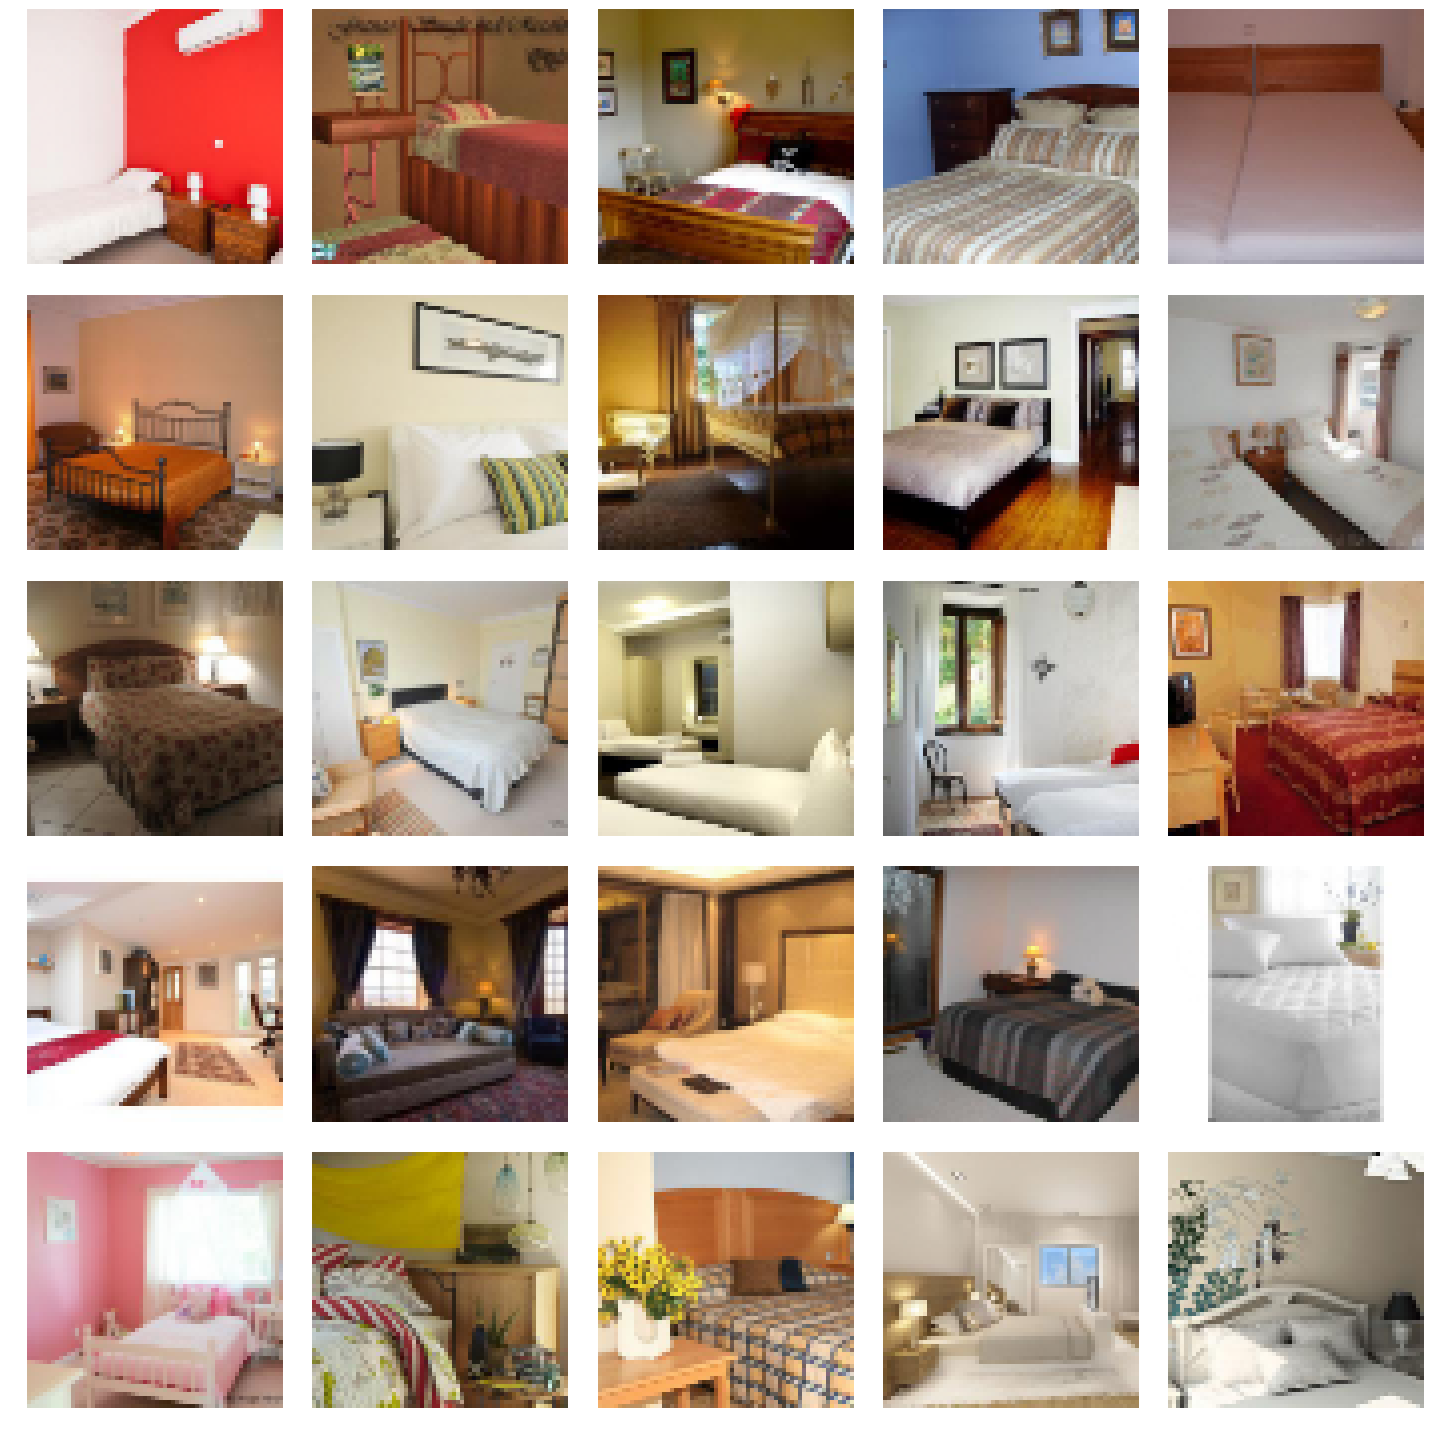

In [18]:
data.show_batch(rows=5)

torch.Size([3, 389, 256])


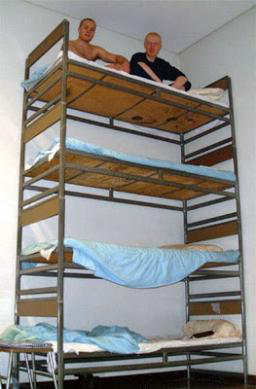

In [19]:
print(data.train_ds.y[0].shape)
data.train_ds.y[0]

In [20]:
# from torch.autograd import Variable as V
def create_noise(b): return torch.zeros(b, nz, 1, 1).normal_(0, 1)

In [21]:
bs, sz, nz = 64,64,100

netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
preds = netG(create_noise(4).cuda() )


In [22]:
# Check is in cuda or not?
create_noise(3).is_cuda

False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


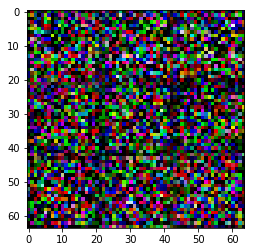

In [23]:
plt.imshow( preds[1].view(64, 64, 3))

In [24]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

In [25]:
# Training loop :D 
from tqdm import tqdm
def train(niter, first=True):
    gen_iterations = 0
    for epoch in range(niter):
        netD.train(); netG.train()
        data_iter = iter(data.train_dl)
        i,n = 0,len(data.train_dl)
        with tqdm(total=n) as pbar:
            while i < n:
                requires_grad(netD, True) # set_trainable(netD, True)
                requires_grad(netG, False) # set_trainable(netG, False)
                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
                j = 0
                while (j < d_iters) and (i < n):
                    j += 1; i += 1
                    for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    real = next(data_iter)[1]
                    real_loss = netD(real)
                    fake = netG(create_noise(real.size(0)).cuda())
                    fake_loss = netD(fake.data)
                    netD.zero_grad()
                    lossD = real_loss-fake_loss
                    lossD.backward()
                    optimizerD.step()
                    pbar.update()

                requires_grad(netD, False) # set_trainable(netD, False)
                requires_grad(netG, True) # set_trainable(netG, True)
                netG.zero_grad()
                lossG = netD(netG(create_noise(bs).cuda())).mean(0).view(1)
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
        
        print(f'Loop #: {gen_iterations}')
        print(f'Loss_D {to_np(lossD)}; Loss_G {to_np(lossG)}; '
              f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')

In [26]:
torch.backends.cudnn.benchmark=True

In [27]:
train(1, False)

100%|██████████| 2368/2368 [03:51<00:00, 10.25it/s]


Loop #: 455
Loss_D [-1.26559]; Loss_G [0.488564]; D_real [-0.566866]; Loss_D_fake [0.698724]


In [28]:
fixed_noise = create_noise(bs)

In [29]:
requires_grad(netD, True)
requires_grad(netG, True)
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

In [30]:
train(25, False)

  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 455
Loss_D [-0.614038]; Loss_G [0.3503]; D_real [-0.024906]; Loss_D_fake [0.589132]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 910
Loss_D [-1.316504]; Loss_G [0.685517]; D_real [-0.665763]; Loss_D_fake [0.650742]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 1365
Loss_D [-1.136782]; Loss_G [0.440827]; D_real [-0.485259]; Loss_D_fake [0.651523]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 1820
Loss_D [-0.89944]; Loss_G [0.288189]; D_real [-0.231535]; Loss_D_fake [0.667905]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 2275
Loss_D [-0.898418]; Loss_G [0.662524]; D_real [-0.645227]; Loss_D_fake [0.25319]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 2730
Loss_D [-0.634414]; Loss_G [0.628525]; D_real [-0.637837]; Loss_D_fake [-0.003423]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 3185
Loss_D [-0.697668]; Loss_G [0.630704]; D_real [-0.622618]; Loss_D_fake [0.07505]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 3640
Loss_D [-0.92608]; Loss_G [0.617413]; D_real [-0.574321]; Loss_D_fake [0.351759]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 4095
Loss_D [-0.88224]; Loss_G [0.337199]; D_real [-0.286787]; Loss_D_fake [0.595453]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 4550
Loss_D [-0.770753]; Loss_G [0.616827]; D_real [-0.563256]; Loss_D_fake [0.207498]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 5005
Loss_D [-0.58609]; Loss_G [0.60354]; D_real [-0.571086]; Loss_D_fake [0.015004]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 5479
Loss_D [-0.671642]; Loss_G [0.590582]; D_real [-0.539222]; Loss_D_fake [0.132419]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 5934
Loss_D [-0.603719]; Loss_G [0.034264]; D_real [-0.023625]; Loss_D_fake [0.580094]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 6389
Loss_D [-0.706757]; Loss_G [0.103902]; D_real [-0.149927]; Loss_D_fake [0.55683]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 6844
Loss_D [-0.625899]; Loss_G [0.155026]; D_real [-0.123283]; Loss_D_fake [0.502616]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 7299
Loss_D [-0.611791]; Loss_G [0.057141]; D_real [-0.068127]; Loss_D_fake [0.543664]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 7754
Loss_D [-0.62361]; Loss_G [0.060644]; D_real [-0.066426]; Loss_D_fake [0.557184]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 8209
Loss_D [-0.538317]; Loss_G [0.022098]; D_real [-0.010701]; Loss_D_fake [0.527616]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 8664
Loss_D [-0.540961]; Loss_G [0.570107]; D_real [-0.512552]; Loss_D_fake [0.028409]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 9119
Loss_D [-0.560029]; Loss_G [-0.026722]; D_real [-0.026746]; Loss_D_fake [0.533283]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 9574
Loss_D [-0.486342]; Loss_G [0.015832]; D_real [0.040879]; Loss_D_fake [0.527221]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 10029
Loss_D [-0.514695]; Loss_G [0.052003]; D_real [-0.045103]; Loss_D_fake [0.469591]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 10501
Loss_D [-0.54113]; Loss_G [-0.010739]; D_real [-0.028383]; Loss_D_fake [0.512747]


  0%|          | 0/2368 [00:00<?, ?it/s]

Loop #: 10975
Loss_D [-0.506658]; Loss_G [-0.107763]; D_real [-0.023268]; Loss_D_fake [0.48339]


100%|██████████| 2368/2368 [03:27<00:00, 11.39it/s]


Loop #: 11430
Loss_D [-0.452726]; Loss_G [0.476187]; D_real [-0.433259]; Loss_D_fake [0.019468]


In [31]:
netD.eval(); netG.eval();
fake = netG(fixed_noise.cuda()).data.cpu()

fake.shape

torch.Size([64, 3, 64, 64])

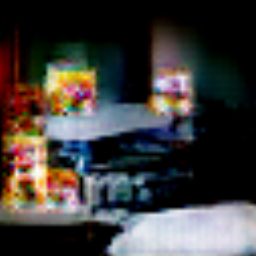

In [39]:
i = data.train_ds.y.reconstruct(fake[13])
# i
i.resize(256)